In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

In [2]:
# Load the data
df_0 = pd.read_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_NIR_1.csv")

In [3]:
# Define the target variable and numeric columns
target = 'thnoth_name'
numeric_cols_df_0 = df_0.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_0 = df_0.select_dtypes(exclude=[np.number]).columns.tolist()

In [ ]:
# Drop non-numeric columns and target column from numeric columns list
# numeric_cols_df_0 = [col for col in numeric_cols_df_0 if col not in string_cols_df_0]

In [4]:
# Train a RandomForest model to get feature importances
X = df_0[numeric_cols_df_0]
y = df_0[target]

In [5]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)

RandomForestClassifier(random_state=42)

In [6]:
# Get feature importances
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # Top 10 features

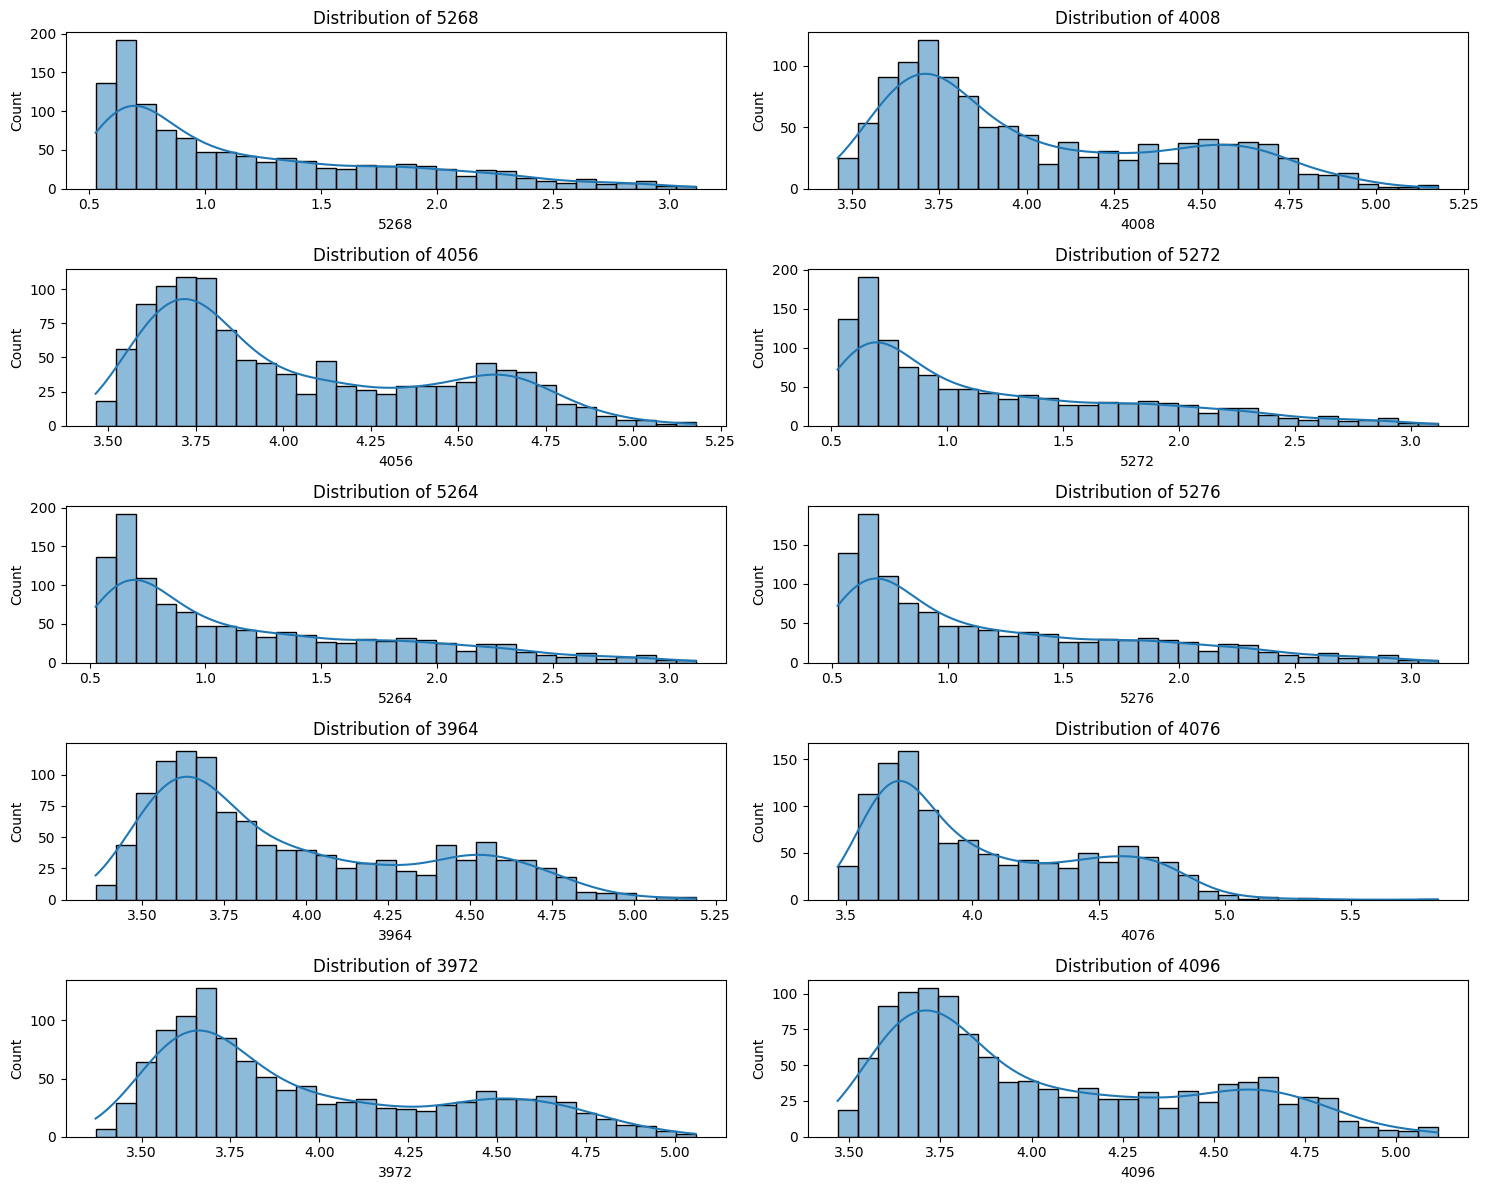

In [7]:
# Plot the distribution of the top 10 most important features
plt.figure(figsize=(15, 12))
for i, idx in enumerate(indices):
    plt.subplot(5, 2, i + 1)
    sns.histplot(df_0[numeric_cols_df_0[idx]], bins=30, kde=True)
    plt.title(f'Distribution of {numeric_cols_df_0[idx]}')
plt.tight_layout()
plt.show()

In [8]:
from scipy import stats

# Define a function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, threshold=3):
    z_scores = np.abs(stats.zscore(df[columns]))
    return df[(z_scores < threshold).all(axis=1)]

# Remove outliers from the top 10 important features
top_features = [numeric_cols_df_0[idx] for idx in indices]
df_0_cleaned = remove_outliers_zscore(df_0, top_features)

# Check the shape of the cleaned dataframe
print("Original Data Shape:", df_0.shape)
print("Cleaned Data Shape:", df_0_cleaned.shape)


Original Data Shape: (1156, 1907)
Cleaned Data Shape: (1150, 1907)


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Split the cleaned data into train and test sets
X_cleaned = df_0_cleaned[numeric_cols_df_0]
y_cleaned = df_0_cleaned[target]

X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.5, random_state=42)

# Train the RandomForest model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Analyze accuracy per 'prov_char'
df_0_test_cleaned = df_0_cleaned.loc[X_test.index]
df_0_test_cleaned['predicted'] = y_pred
df_0_test_cleaned['actual'] = y_test.values

prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())
print(prov_char_analysis)


Classification Report:
               precision    recall  f1-score   support

    Non-Thai       0.54      0.45      0.49       221
        Thai       0.69      0.76      0.72       354

    accuracy                           0.64       575
   macro avg       0.62      0.61      0.61       575
weighted avg       0.63      0.64      0.64       575

Confusion Matrix:
 [[100 121]
 [ 84 270]]
prov_char
BBX    0.416667
CBI    0.888889
CCO    1.000000
CPN    0.740741
KAX    0.571429
KBI    0.767123
KBX    0.455882
KTX    0.500000
NRT    0.875000
NWT    0.733333
RIX    0.416667
SGR    0.666667
SNI    0.721311
SNK    1.000000
SUX    0.583333
TRG    0.755556
dtype: float64


C:\Users\pingk\AppData\Local\Temp\ipykernel_28232\4156967957.py:25: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prov_char_analysis = df_0_test_cleaned.groupby('prov_char').apply(lambda x: (x['actual'] == x['predicted']).mean())


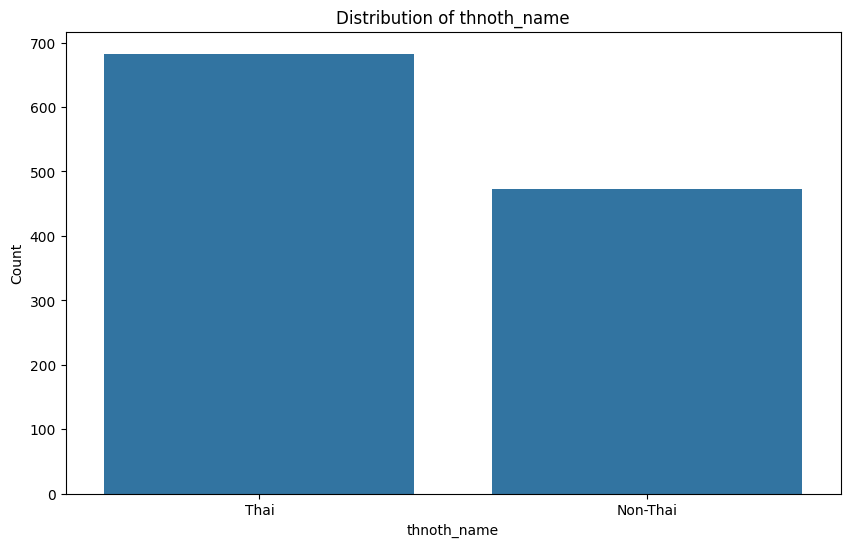

In [10]:
# Create a distribution plot for 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=df_0, x=target)
plt.title('Distribution of thnoth_name')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()

In [11]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_0_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        681
Non-Thai    469
Name: count, dtype: int64


In [13]:
# Separate Thai and Non-Thai samples
df_0_cleaned_thai = df_0_cleaned[df_0_cleaned[target] == 'Thai']
df_0_cleaned_non_thai = df_0_cleaned[df_0_cleaned[target] == 'Non-Thai']

In [14]:
from sklearn.ensemble import IsolationForest

# Identify and remove outliers in Thai samples using Isolation Forest
iso = IsolationForest(contamination=0.1, random_state=42)
yhat = iso.fit_predict(df_0_cleaned_thai[numeric_cols_df_0])
mask = yhat != -1
df_0_cleaned_thai_cleaned = df_0_cleaned_thai[mask]

In [15]:
# Combine the cleaned Thai samples with Non-Thai samples

df_1_cleaned = pd.concat([df_0_cleaned_thai_cleaned, df_0_cleaned_non_thai], axis=0).reset_index(drop=True)

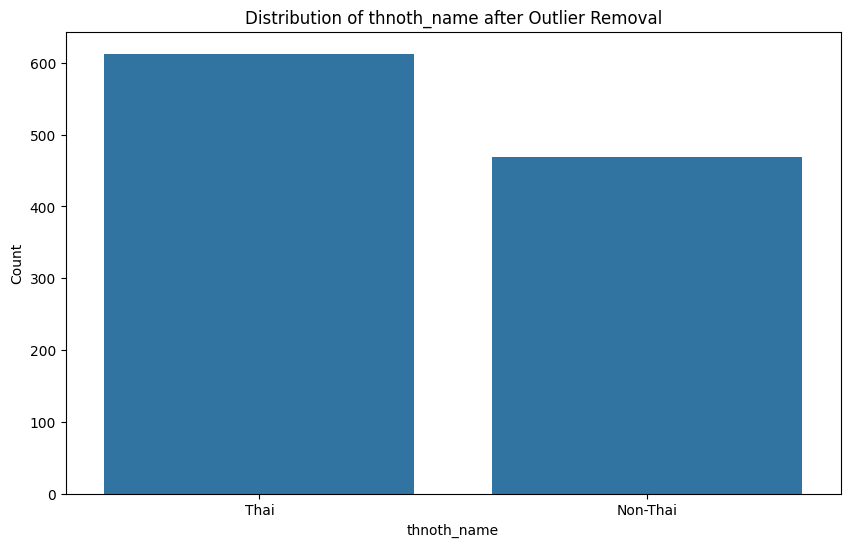

In [16]:
# Plot the distribution of thnoth_name after outlier removal
plt.figure(figsize=(10, 6))
sns.countplot(data=df_1_cleaned, x=target)
plt.title('Distribution of thnoth_name after Outlier Removal')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


In [17]:
# Verify the new distribution
print("New distribution of thnoth_name:")
print(df_1_cleaned[target].value_counts())

New distribution of thnoth_name:
thnoth_name
Thai        613
Non-Thai    469
Name: count, dtype: int64


In [19]:
df_2 = df_1_cleaned.copy()

In [ ]:
df_2.head()

In [21]:
from sklearn.preprocessing import LabelEncoder

# Encoding the 'thnoth_name' column
le = LabelEncoder()
df_2['thnoth_name_encoded'] = le.fit_transform(df_2['thnoth_name'])

In [22]:
# Define the target variable and numeric columns
numeric_cols_df_2 = df_2.select_dtypes(include=[np.number]).columns.tolist()
string_cols_df_2 = df_2.select_dtypes(exclude=[np.number]).columns.tolist()

# Drop non-numeric columns and target column from numeric columns list
numeric_cols_df_2 = [col for col in numeric_cols_df_2 if col not in string_cols_df_2]

In [23]:
# Train a RandomForest model to get feature importances
X_df_2 = df_2[numeric_cols_df_2].drop(columns=['thnoth_name_encoded'])
y_df_2 = df_2['thnoth_name_encoded'].values

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.under_sampling import RandomUnderSampler

# Initial model training to find consistent samples
rf = RandomForestClassifier(random_state=42)
rf.fit(X_df_2, y_df_2)

# Get predictions
df_2['predictions'] = rf.predict(X_df_2)

# Keep samples that are correctly classified
consistent_samples = df_2[df_2['thnoth_name_encoded'] == df_2['predictions']]

# Separate features and target again with consistent samples
X_df_2_consistent = consistent_samples.drop(columns=['thnoth_name', 'thnoth_name_encoded', 'predictions'])
y_df_2_consistent = consistent_samples['thnoth_name_encoded'].values

# Ensure X_df_2_consistent contains only numeric columns
X_df_2_consistent = X_df_2_consistent.select_dtypes(include=[np.number])

# Map for original string labels to numeric encoded labels
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))

# Step 8: Apply undersampling to achieve a balanced dataset
rus = RandomUnderSampler(sampling_strategy={label_mapping['Thai']: 469, label_mapping['Non-Thai']: 469}, random_state=42)
X_df_2_balanced, y_df_2_balanced = rus.fit_resample(X_df_2_consistent, y_df_2_consistent)

# Step 9: Display the new distribution of 'thnoth_name'
balanced_df = consistent_samples.iloc[rus.sample_indices_]
thnoth_name_distribution = balanced_df['thnoth_name'].value_counts()
print(thnoth_name_distribution)


thnoth_name
Non-Thai    469
Thai        469
Name: count, dtype: int64


In [ ]:
balanced_df.drop(columns=['predictions'], inplace=True)
balanced_df

In [27]:
balanced_df.reset_index(drop=True)

,prov_char,country_char,wavenumber,11544,11540,11536,11532,11528,11524,11520,...,3964,3960,3956,3952,tgp_name,dgp_name,fgp_name,country_name,thnoth_name,thnoth_name_encoded
0,KAX,ID,ID-KAX-088-2401-001,0.290252,0.290122,0.290044,0.290029,0.290042,0.289978,0.289851,...,3.558086,3.542757,3.530849,3.501222,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0
1,KBX,ID,ID-KBX-068-2306-003,0.522845,0.522798,0.522826,0.522669,0.522414,0.522217,0.522070,...,3.680422,3.655416,3.629388,3.606223,Group 3,Group 2,Group 4,Indonesia,Non-Thai,0
2,BBX,ID,ID-BBX-095-2401-004,-0.144108,-0.144008,-0.143893,-0.143777,-0.143686,-0.143667,-0.143678,...,3.650478,3.623180,3.614590,3.581875,Group 3,Group 2,Group 3,Indonesia,Non-Thai,0
3,SUX,ID,ID-SUX-074-2311-001,0.333905,0.333777,0.333785,0.333700,0.333522,0.333453,0.333446,...,3.601331,3.566453,3.539593,3.512285,Group 3,Group 2,Group 3,Indonesia,Non-Thai,0
4,SUX,ID,ID-SUX-073-2311-001,0.067265,0.067248,0.067189,0.067098,0.067036,0.067068,0.067134,...,3.572230,3.543391,3.533726,3.523198,Group 3,Group 2,Group 3,Indonesia,Non-Thai,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
933,CPN,TH,TH-CPN-006-2312-003,0.461643,0.461632,0.461639,0.461582,0.461498,0.461418,0.461337,...,3.656118,3.624759,3.602149,3.571732,Group 2,Group 2,Group 2,Thailand,Thai,1
934,KBI,TH,TH-KBI-011-2312-006,-0.002817,-0.002784,-0.002774,-0.002774,-0.002727,-0.002666,-0.002697,...,3.525139,3.508492,3.505676,3.496750,Group 2,Group 2,Group 2,Thailand,Thai,1
935,KBI,TH,TH-KBI-011-2312-008,0.092280,0.092246,0.092173,0.092116,0.092086,0.092090,0.092090,...,3.538429,3.524016,3.511641,3.478896,Group 2,Group 2,Group 2,Thailand,Thai,1
936,SNI,TH,TH-SNI-012-2312-007,1.853667,1.854380,1.855884,1.856258,1.854698,1.852529,1.851278,...,4.450503,4.405548,4.411911,4.395426,Group 2,Group 2,Group 3,Thailand,Thai,1


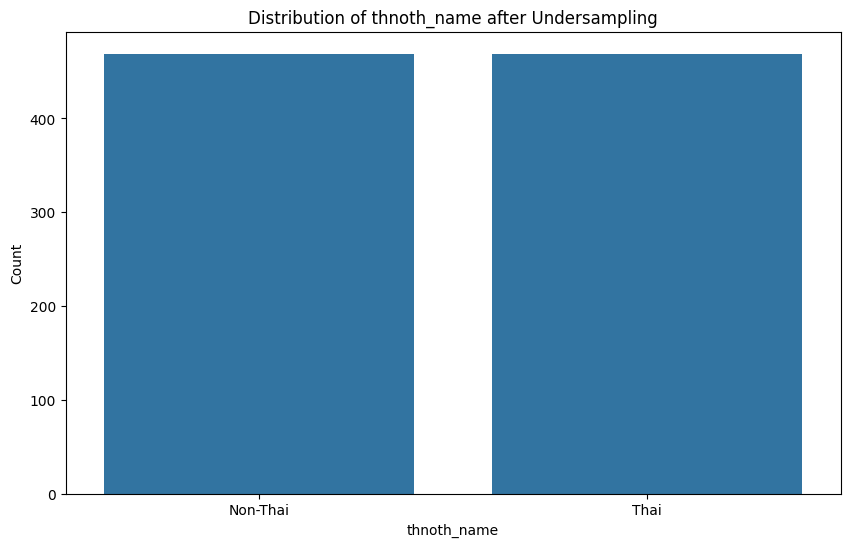

In [28]:
# Check the distribution of 'thnoth_name' after undersampling

import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of 'thnoth_name'
plt.figure(figsize=(10, 6))
sns.countplot(data=balanced_df, x='thnoth_name')
plt.title('Distribution of thnoth_name after Undersampling')
plt.xlabel('thnoth_name')
plt.ylabel('Count')
plt.show()


Mean Accuracy: 0.5145451882965464
Left out group: ['BBX'], Accuracy: 0.4
Left out group: ['CBI'], Accuracy: 0.6923076923076923
Left out group: ['CCO'], Accuracy: 0.5384615384615384
Left out group: ['CPN'], Accuracy: 0.6164383561643836
Left out group: ['KAX'], Accuracy: 0.35714285714285715
Left out group: ['KBI'], Accuracy: 0.4838709677419355
Left out group: ['KBX'], Accuracy: 0.41007194244604317
Left out group: ['KTX'], Accuracy: 0.6666666666666666
Left out group: ['NRT'], Accuracy: 0.46153846153846156
Left out group: ['NWT'], Accuracy: 0.875
Left out group: ['RIX'], Accuracy: 0.20192307692307693
Left out group: ['SGR'], Accuracy: 0.7777777777777778
Left out group: ['SNI'], Accuracy: 0.43670886075949367
Left out group: ['SNK'], Accuracy: 0.0
Left out group: ['SUX'], Accuracy: 0.8148148148148148
Left out group: ['TRG'], Accuracy: 0.5


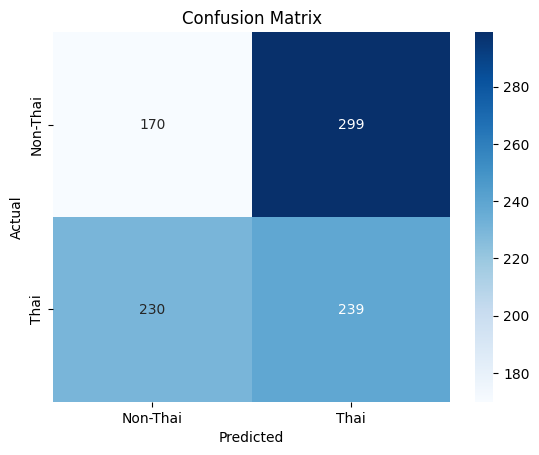

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Initialize and encode the 'prov_char' column
le_prov = LabelEncoder()
prov_char_encoded = le_prov.fit_transform(balanced_df['prov_char'])

# Define features and target for the balanced dataset
X_balanced = balanced_df.drop(columns=['thnoth_name', 'thnoth_name_encoded'])
y_balanced = balanced_df['thnoth_name_encoded'].values

# Ensure X_balanced contains only numeric columns
X_balanced = X_balanced.select_dtypes(include=[np.number])

# Initialize LOGO-CV
logo = LeaveOneGroupOut()

# Arrays to store results
accuracies = []
left_out_groups = []
all_y_test = []
all_y_pred = []

# Perform LOGO-CV
for train_idx, test_idx in logo.split(X_balanced, y_balanced, groups=prov_char_encoded):
    X_train, X_test = X_balanced.iloc[train_idx], X_balanced.iloc[test_idx]
    y_train, y_test = y_balanced[train_idx], y_balanced[test_idx]
    
    # Train the model
    rf.fit(X_train, y_train)
    
    # Predict and evaluate
    y_pred = rf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    # Store results
    accuracies.append(accuracy)
    left_out_groups.append(balanced_df['prov_char'].iloc[test_idx].unique())
    all_y_test.extend(y_test)
    all_y_pred.extend(y_pred)

# Calculate mean accuracy
mean_accuracy = np.mean(accuracies)
print(f'Mean Accuracy: {mean_accuracy}')

# Display left out groups and their accuracies
for group, acc in zip(left_out_groups, accuracies):
    print(f'Left out group: {group}, Accuracy: {acc}')

# Generate confusion matrix
conf_matrix = confusion_matrix(all_y_test, all_y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
#balanced_df.to_csv(r"C:\Users\pingk\Downloads\fadhli nitip\asik_NIR_BLNCD_2.csv", index=False)